# L18_supernova_distances

First let's fit our supernova synthetic data from last time using GPR.

- The key ingrediente in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- *Hint*. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. We have time constraints, so feel free to tweak the hyperparameters manually while in class. But, of course, a publication-quality result will require a cross-validation analysis. (Do this at home before the exam?)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

Text(0, 0.5, '$\\mu$')

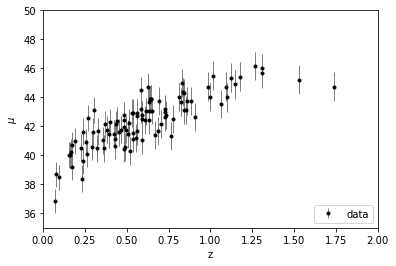

In [2]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.xlabel('z')
plt.ylabel('$\mu$')

Taking the hint above, I have used the RBF Kernel multiplied by a Constant Kernel, as the default GPR does. Then I need to set the parameter $\alpha$ which is a small constant added to the diagonal in order for the determinant not to be null. This constant can be different for each data point, for this reason one choice could be to initialise $\alpha$ as the relative error squared of the samples. In our dataset this is a very small number and the kernel requires the addition of a WhiteNoise Kernel, that adds a constant term on the diagonal. Therefore another solution without the use of the WhiteNoise Kernel could be to fix $\alpha$ as the variance of the samples. 
I tried to implement both these two algorithms below. The optimal value for the white noise kernel is of the same order of the difference $(\mathrm{d}\mu)^2 - (\frac{\mathrm{d}\mu}{\mu})^2$.

So here I summarize all the kernels I use and the plots below are showing the two different regression functions, the first found fixing $\alpha$ as the relative uncertainty squared and adding the white noise kernel, the second with $\alpha$ being just the variance of the samples.

Kernels:

$$K_{\mathrm{RBF}}(x_i, x_j) = \exp \left(- \frac{(x_i - x_j)^2}{2l^2} \right)$$

$$K_{\mathrm{WN}}(x_i, x_j) = c \mathrm{,     if } x_i = x_j$$

$$K_{\mathrm{const}}(x_i, x_j) = c' $$

RBF(length_scale=3.93) * 30.5**2 + WhiteKernel(noise_level=0.842)


Text(0.5, 1.0, 'GPR: $\\alpha = ({\\frac{\\mathrm{d}\\mu}{\\mu}})^2$, Kernel = RBF*Const+WN')

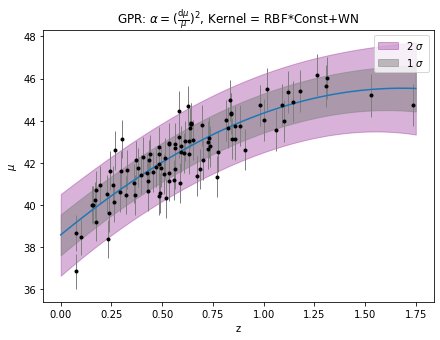

In [3]:
#Here I have white noise kernel and alpha= (dmu/mu)**2
kernel1 = kernels.RBF(0.5, (1e-3, 1e5)) * kernels.ConstantKernel(1e2, (1, 1e6)) + kernels.WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-10, 1))

gp1 = GaussianProcessRegressor(kernel=kernel1, alpha=(dmu/mu_sample)**2)
gp1.fit(z_sample[:, None], mu_sample)
z_lin = np.linspace(0,1.75, 100)
mu_pred, mu_pred_err = gp1.predict(z_lin[:, None], return_std=True)
print(gp1.kernel_)

fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
ax.plot(z_lin, mu_pred)
ax.fill_between(z_lin, mu_pred - 2*mu_pred_err, mu_pred + 2*mu_pred_err, color='purple', alpha=0.3, label='2 $\sigma$')
ax.fill_between(z_lin, mu_pred - mu_pred_err, mu_pred + mu_pred_err, color='gray', alpha=0.5, label='1 $\sigma$')
ax.set_xlabel('z')
ax.set_ylabel('$\mu$')
ax.legend()
ax.set_title(r'GPR: $\alpha = ({\frac{\mathrm{d}\mu}{\mu}})^2$, Kernel = RBF*Const+WN')

The difference between the two alpha is about:  0.8979687265767508
RBF(length_scale=3.93) * 30.5**2


Text(0.5, 1.0, 'GPR: $\\alpha = \\mathrm{d}\\mu^2$, Kernel = RBF*Const')

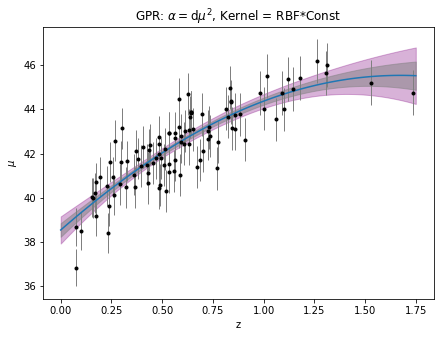

In [4]:
#Here I have no white noise kernel and alpha = dmu**2
kernel2 = kernels.RBF(3.93, 'fixed') * kernels.ConstantKernel(30.5**2, 'fixed') #+ kernels.WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-10, 1))

print('The difference between the two alpha is about: ', np.mean(dmu**2) - np.mean((dmu/mu_sample)**2))

gp2 = GaussianProcessRegressor(kernel=kernel2, alpha=(dmu)**2)
gp2.fit(z_sample[:, None], mu_sample)
z_lin = np.linspace(0,1.75, 100)
mu_pred, mu_pred_err = gp2.predict(z_lin[:, None], return_std=True)
print(gp2.kernel_)

fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
ax.plot(z_lin, mu_pred)
ax.fill_between(z_lin, mu_pred - 2*mu_pred_err, mu_pred + 2*mu_pred_err, color='purple', alpha=0.3, label='2 $\sigma$')
ax.fill_between(z_lin, mu_pred - mu_pred_err, mu_pred + mu_pred_err, color='gray', alpha=0.5, label='1 $\sigma$')
ax.set_xlabel('z')
ax.set_ylabel('$\mu$')
ax.set_title(r'GPR: $\alpha = \mathrm{d}\mu^2$, Kernel = RBF*Const')

Of course in the first case the uncertainty bands are more homogeneous than in the second case, where we see that in correspondence of a high density of points the width of these bands is shrinking, while at high redshifts, where we have less data, it is wider. I think that the choice between the two models really depends on how confident you are in your data and how "conservative" you would like to be in the anaysis. However the second function has more realistic uncertainties, since at high redshift they are predicted to be larger.

How does the function change if I perturb the hyperparameters? Here I try first to change the $l$ parameter, which is the bandwidth of the RBF Kernel: you could see how a change of one order of magnitude can easily produce an overfitting or an underfitting function. Then I try change the constant kernel $c$, the fit seems to be less dependent on this hyperparameter but of course we can see that it has some influence on the slope of the curve and on the uncertainty bands.

RBF(length_scale=0.05) * 30.5**2
RBF(length_scale=50) * 30.5**2
RBF(length_scale=3.93) * 1**2
RBF(length_scale=3.93) * 7.75e+03**2


C:\Users\carlo\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Text(0.5, 1.0, '$c=5e7$, $l_{RBF}=3.93$')

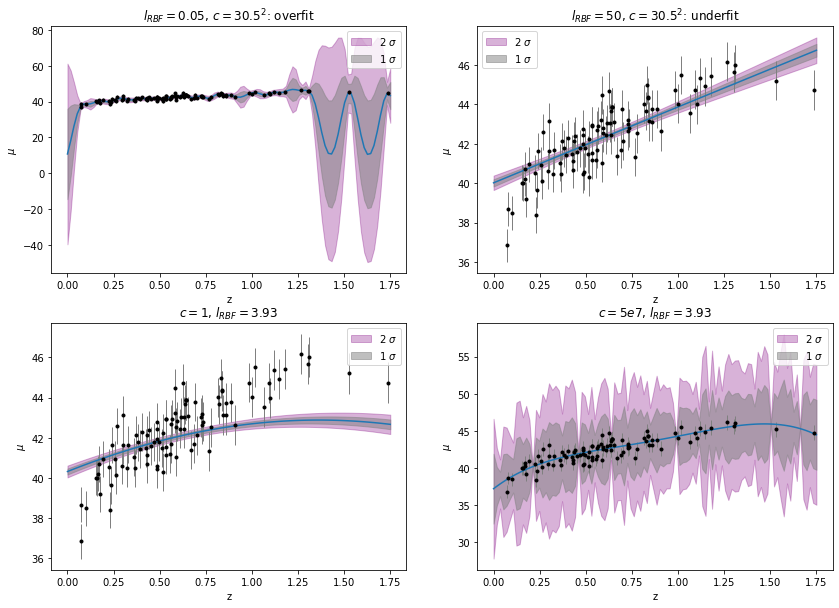

In [5]:
#Here I have white noise kernel and alpha= (dmu/mu)**2
kernel3 = kernels.RBF(0.05, 'fixed') * kernels.ConstantKernel(30.5**2, 'fixed') #+ kernels.WhiteKernel(0.89,'fixed')

gp3 = GaussianProcessRegressor(kernel=kernel3, alpha=(dmu)**2)
gp3.fit(z_sample[:, None], mu_sample)
z_lin = np.linspace(0,1.75, 100)
mu_pred, mu_pred_err = gp3.predict(z_lin[:, None], return_std=True)
print(gp3.kernel_)

kernel4 = kernels.RBF(50, 'fixed') * kernels.ConstantKernel(30.5**2, 'fixed') #+ kernels.WhiteKernel(0.89, 'fixed')
gp4 = GaussianProcessRegressor(kernel=kernel4, alpha=(dmu)**2)
gp4.fit(z_sample[:, None], mu_sample)
z_lin = np.linspace(0,1.75, 100)
mu_pred4, mu_pred_err4 = gp4.predict(z_lin[:, None], return_std=True)
print(gp4.kernel_)

kernel5 = kernels.RBF(3.93, 'fixed') * kernels.ConstantKernel(1, 'fixed') #+ kernels.WhiteKernel(0.89, 'fixed')
gp5 = GaussianProcessRegressor(kernel=kernel5, alpha=(dmu)**2)
gp5.fit(z_sample[:, None], mu_sample)
z_lin = np.linspace(0,1.75, 100)
mu_pred5, mu_pred_err5 = gp5.predict(z_lin[:, None], return_std=True)
print(gp5.kernel_)

kernel6 = kernels.RBF(3.93, 'fixed') * kernels.ConstantKernel(6e7, 'fixed') #+ kernels.WhiteKernel(0.89, 'fixed')
gp6 = GaussianProcessRegressor(kernel=kernel6, alpha=(dmu)**2)
gp6.fit(z_sample[:, None], mu_sample)
z_lin = np.linspace(0,1.75, 100)
mu_pred6, mu_pred_err6 = gp6.predict(z_lin[:, None], return_std=True)
print(gp6.kernel_)

fig, ax = plt.subplots(2,2, figsize=(14,10))
ax = ax.reshape(4)

for i in range(len(ax)):
    ax[i].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
    ax[i].set_xlabel('z')
    ax[i].set_ylabel('$\mu$')

ax[0].plot(z_lin, mu_pred)
ax[0].fill_between(z_lin, mu_pred - 2*mu_pred_err, mu_pred + 2*mu_pred_err, color='purple', alpha=0.3, label='2 $\sigma$')
ax[0].fill_between(z_lin, mu_pred - mu_pred_err, mu_pred + mu_pred_err, color='gray', alpha=0.5, label='1 $\sigma$')
ax[0].legend()
ax[0].set_title(r'$l_{RBF}=0.05$, $c = 30.5^2$: overfit')

ax[1].plot(z_lin, mu_pred4)
ax[1].fill_between(z_lin, mu_pred4 - 2*mu_pred_err4, mu_pred4 + 2*mu_pred_err4, color='purple', alpha=0.3, label='2 $\sigma$')
ax[1].fill_between(z_lin, mu_pred4 - mu_pred_err4, mu_pred4 + mu_pred_err4, color='gray', alpha=0.5, label='1 $\sigma$')
ax[1].legend()
ax[1].set_title(r'$l_{RBF}=50$, $c = 30.5^2$: underfit')

ax[2].plot(z_lin, mu_pred5)
ax[2].fill_between(z_lin, mu_pred5 - 2*mu_pred_err5, mu_pred5 + 2*mu_pred_err5, color='purple', alpha=0.3, label='2 $\sigma$')
ax[2].fill_between(z_lin, mu_pred5 - mu_pred_err5, mu_pred5 + mu_pred_err5, color='gray', alpha=0.5, label='1 $\sigma$')
ax[2].legend()
ax[2].set_title(r'$c=1$, $l_{RBF}=3.93$')

ax[3].plot(z_lin, mu_pred6)
ax[3].fill_between(z_lin, mu_pred6 - 2*mu_pred_err6, mu_pred6 + 2*mu_pred_err6, color='purple', alpha=0.3, label='2 $\sigma$')
ax[3].fill_between(z_lin, mu_pred6 - mu_pred_err6, mu_pred6 + mu_pred_err6, color='gray', alpha=0.5, label='1 $\sigma$')
ax[3].legend()
ax[3].set_title(r'$c=5e7$, $l_{RBF}=3.93$')


We now have a suite of *data-drive predictive models* for our supernova dataset. That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample.

This is already great and these kind of tools are immensely useful in a variety of contexts (also involving a lot of money: suppose you want to predict how much a give financial asset will perform on tomorrow's stock market... You  might not really care about expressing the underlying financial model in simple terms, as long as your investments are profitable).

For the case of supernovae, however, we have a physical theory which is $\Lambda$CDM.

- First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $z$. *Hint* I always forget these things, my to-go reference is [Hogg (2010)](https://arxiv.org/abs/astro-ph/9905116). I got:

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$


- Assuming a flat Universe,  we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$
- It's a very non-linear model. Fir it to the data (however you want to do it).
- What are the measured value of $H_0$ and $\Omega_m$. Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m=1$) perform? Do these data contain evidence of dark energy?

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much better.
- Assume a uniform distribution in redshifts between 0 and z.
- Using both the GPR fit and your latest $\Lambda$CDM fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given. 



## Fitting the theoretical curve in a flat Universe 

Here I use dynesty to fit for the best parameters and compare models.

In [6]:
from astropy.cosmology import FlatLambdaCDM
import corner
import warnings; warnings.simplefilter('ignore')
import dynesty

def mu(z, H_0, Omegam):
    cosmology = FlatLambdaCDM(H0 = H_0, Om0 = Omegam)
    return cosmology.distmod(z).value

#Assuming gaussian errors
def loglike(x):
    return np.sum(-(mu_sample - mu(z_sample, x[0], x[1]))**2/(2*dmu**2))

def prior(u):
    x = np.array(u)
    x[0] = u[0]*100+1   #H0 prior  
    x[1] = u[1]*1 +0.01 #Om0 prior
    return x

C:\Users\carlo\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [7]:
sampler = dynesty.NestedSampler(loglike, prior, ndim=2, nlive=1500 )
sampler.run_nested()
sresults = sampler.results
sresults.summary()

4335it [00:23, 186.23it/s, +1500 | bound: 0 | nc: 1 | ncall: 25578 | eff(%): 22.813 | loglstar:   -inf < -46.385 <    inf | logz: -49.325 +/-  0.025 | dlogz:  0.001 >  1.509]

Summary
nlive: 1500
niter: 4335
ncall: 25578
eff(%): 22.813
logz: -49.325 +/-  0.025


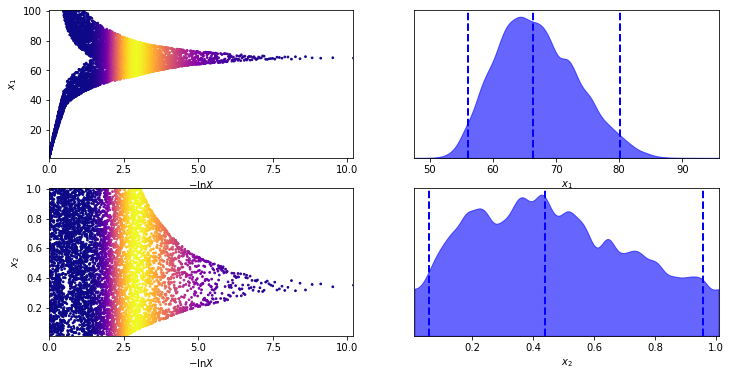

In [8]:
from dynesty import plotting as dyplot

tfig, taxes = dyplot.traceplot(sresults)

16-50-84 percentiles are: 
H_0 :  [60.59924549528723, 66.42021507388682, 73.39646063715544] 
Om :  [0.18783931299015658, 0.43952371280227925, 0.7572192808969075]


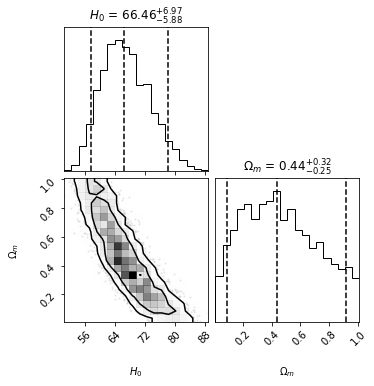

In [9]:
from dynesty import utils as dyfunc

samples = sresults.samples 

#Normalized Weights
weights = np.exp(sresults.logwt - sresults.logz[-1])

# Compute median and 1sigma intervals.
quantiles = [dyfunc.quantile(samps, [0.16, 0.50, 0.84], weights=weights)
             for samps in samples.T]
print('16-50-84 percentiles are: \nH_0 : ', str(quantiles[0]), '\nOm : ', str(quantiles[1]))

# Resample weighted samples.
samples_equal = dyfunc.resample_equal(samples, weights)

import corner
fig = corner.corner(samples_equal, levels=(0.68, 0.95), quantiles=(0.05, 0.5, 0.95), labels=[r'$H_0$', r'$\Omega_m$'],
                    title_quantiles = (0.05, 0.5, 0.95), show_titles=True)

With dynesty we can see how the two parameters $H_0$ and $\Omega_m$ are correlated. Infact as $H_0$ increases $\Omega_m$ decreases, this was expected from theory since in the equation written above both terms are at the denominator. The parameter $H_0$ is fully compatible with the results from the Planck survey ($H_0 = 67.74 \pm 0.46$ km/s/Mpc (2015)) and the uncertainty on the parameter makes it also compatible with the value observed from SNIa in 2016 ($H_0 = 73.24 \pm 1.74$ km/s/Mpc). From these observations we could say that our result is alligned with previous studies, but it doesn't really help in solving the problem of the so-called "Hubble tension" since the uncertainties are very large.

Also the parameter $\Omega_m$ found by our fit is alligned with the value observed in 2015 by the Planck project $\Omega_m \simeq 0.310$.


Let's plot some curves extracted from the posterior distribution of parameters.

Text(0.5, 1.0, '100 random results from the posterior')

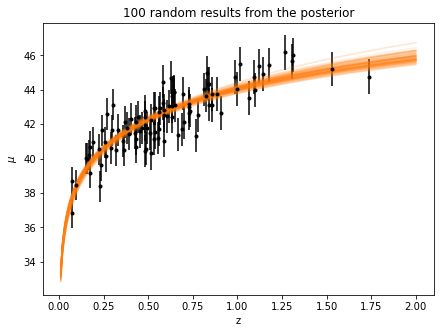

In [10]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.errorbar(z_sample, mu_sample, dmu, fmt='.k')
z_linsp = np.linspace(0,2,200)

#extracting random couples of parameters from the posterior distribution
random_ind = np.random.randint(low=0, high=len(samples_equal), size=100, dtype=int)
random_samples = samples_equal[random_ind]

for i in range(len(random_samples)):
    ax.plot(z_linsp, mu(z_linsp, random_samples[i,0], random_samples[i,1]),
           alpha = 0.1, c='tab:orange')
ax.set_xlabel('z')
ax.set_ylabel('$\mu$')
ax.set_title('100 random results from the posterior')

## Fitting the theoretical curve in a flat Universe without dark energy

Assuming that there's no Dark Energy in the Universe ($\Omega_{\Lambda} = 0$, $\Omega_{m} = 1$) how does the model change? From the correlation found before, since $\Omega_{m}$ is fixed at a high value of 1, I would expect $H_0$ to be lower than what has been found before.

Is the model still good enough to represent our data? 

To answer these questions I run another dynesty algorithm to get the result of the only free parameter ($H_{0}$) and look at the changes in the model.

In [11]:
def mu2(z, H_0):
    cosmology = FlatLambdaCDM(H0 = H_0, Om0 = 1) #omega_m = 1 since we have Omega_lambda = 0
    return cosmology.distmod(z).value

def loglike(x):
    return np.sum(-(mu_sample - mu2(z_sample, x[0]))**2/(2*dmu**2))

def prior(u):
    x = np.array(u)
    x[0] = u[0]*100+1   #H0 prior  
    return x

sampler_node = dynesty.NestedSampler(loglike, prior, ndim=1, nlive=1500 )
sampler_node.run_nested()
sresults_node = sampler_node.results
sresults_node.summary()

4304it [00:18, 231.91it/s, +1500 | bound: 0 | nc: 1 | ncall: 26586 | eff(%): 21.831 | loglstar:   -inf < -47.102 <    inf | logz: -49.874 +/-    nan | dlogz:  0.001 >  1.509]

Summary
nlive: 1500
niter: 4304
ncall: 26586
eff(%): 21.831
logz: -49.874 +/-    nan


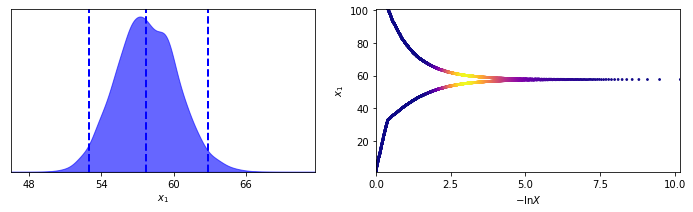

In [12]:
tfig, taxes = dyplot.traceplot(sresults_node)

In [13]:
samples_node = sresults_node.samples 

#Normalized Weights
weights_node = np.exp(sresults_node.logwt - sresults_node.logz[-1])

# Compute median and 1sigma intervals.
quantiles_node = [dyfunc.quantile(samps, [0.16, 0.50, 0.84], weights=weights_node)
             for samps in samples_node.T]
print('16-50-84 percentiles are: \nH_0 : ', str(quantiles_node[0]))

samples_equal_node = dyfunc.resample_equal(samples_node, weights_node)

16-50-84 percentiles are: 
H_0 :  [55.260181605312134, 57.70246544827284, 60.22512755225474]


As predicted this time the median value of $H_0$ is lower, around 57 km/s/Mpc, while in the previous model it was around 66 km/s/Mpc.

Text(0.5, 1.0, '100 random results from the posterior')

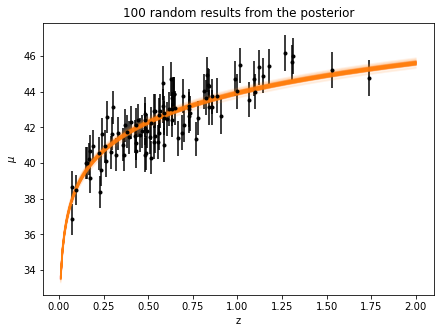

In [14]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.errorbar(z_sample, mu_sample, dmu, fmt='.k')
z_linsp = np.linspace(0,2,200)

#extracting random couples of parameters from the posterior distribution
random_ind = np.random.randint(low=0, high=len(samples_equal_node), size=100, dtype=int)
random_samples = samples_equal_node[random_ind]

for i in range(len(random_samples)):
    ax.plot(z_linsp, mu2(z_linsp, random_samples[i,0]),
           alpha = 0.1, c='tab:orange')
ax.set_xlabel('z')
ax.set_ylabel('$\mu$')
ax.set_title('100 random results from the posterior')

Data seem to be well described by both models, however to have a quantitative way to compare them we can evaluate the Bayes' factor. 

$$B_{21} = \frac{E(M_{DE})}{E(M_{no DE})}$$

In [15]:
evid   = np.exp(sresults.logz[-1])
evid_node = np.exp(sresults_node.logz[-1])
print('The Bayes factor B_21 between M2 = with DE and M1 = no DE is: ', evid/evid_node)

The Bayes factor B_21 between M2 = with DE and M1 = no DE is:  1.730657051706175


Eventhough there's no strong evidence that one model is better than the other, the flat Universe with Dark Energy is still preferred, as testified by the Bayes' factor, that if we assume equal priors on both models is equivalent to the odds ratio. 

In conclusion I would not state that these data are highlighting the need of Dark Energy, but for further analysis I would use the model with $\Omega_m \neq 1$.

## Generating new measurements

To generate new measurements from the fitting function with Dark Energy taking into consideration uncertainties, what one can do is evaluate the function at each redshift point using each time different parameters extracted from the posterior.

In [16]:
z_new = np.random.uniform(0,2,1000) #extracting 1000 values of uniformly distributed z

y_f = [] #extracted samples from the fitted function

for i in range(len(z_new)):
    #extract a parameter vector from the posterior
    random_ind = np.random.randint(low=0, high=len(samples_equal), dtype=int)
    random_samples = samples_equal[random_ind] 
    
    #evaluate the function at a given redshift with the extracted parameter
    y_f.append(mu(z_new[i],random_samples[0],random_samples[1]))
    

In Gaussian Process Regression instead at each redshift point we have a mean and a standard deviation, therefore we can extract a sample from a Gaussian using these parameters. Here I extract samples from both GPR results.

In [17]:
#GPR with white noise
y_gpr = []

#predicting the mean and sigma for each new sample
mean_gpr, std_gpr = gp1.predict(z_new[:,None], return_std=True)

#extracting from gaussians
for i in range(len(z_new)):
    y_gpr.append(np.random.normal(mean_gpr[i], std_gpr[i]))

    
    
#GPR without white noise
y_gpr2 = []

#predicting the mean and sigma for each new sample
mean_gpr2, std_gpr2 = gp2.predict(z_new[:,None], return_std=True)

#extracting from gaussians
for i in range(len(z_new)):
    y_gpr2.append(np.random.normal(mean_gpr2[i], std_gpr2[i]))

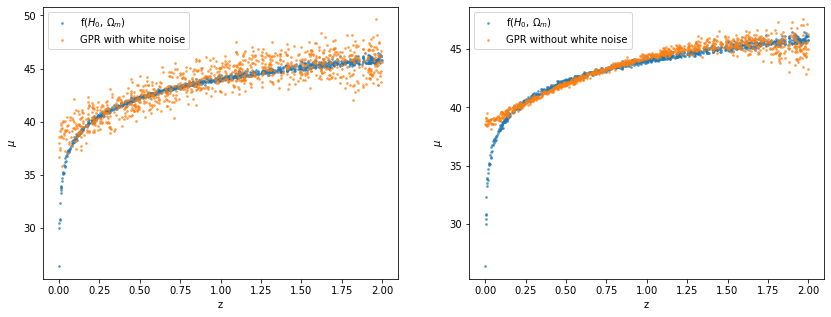

In [18]:
fig, ax = plt.subplots(1,2, figsize=(14,5))

ax[0].scatter(z_new, y_f, s=3, alpha=0.6, label='f($H_0$, $\Omega_m$)')
ax[0].scatter(z_new, y_gpr, s=3, alpha=0.6, label='GPR with white noise')
ax[0].set_xlabel('z')
ax[0].set_ylabel('$\mu$')
ax[0].legend()

ax[1].scatter(z_new, y_f, s=3, alpha=0.6, label='f($H_0$, $\Omega_m$)')
ax[1].scatter(z_new, y_gpr2, s=3, alpha=0.6, label='GPR without white noise')
ax[1].set_xlabel('z')
ax[1].set_ylabel('$\mu$')
ax[1].legend()

The orange points are the ones predicted based only on previous data, while the blue ones are predicted combining data and theory. The big difference is at low redshift, where the two functions have different shapes. The standard deviation of data at a given redshift really depends on which GPR model we choose. 